In [69]:
import os, sys

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
import seaborn as sns
import control as ctl

In [71]:
data_dir = "../data/2022-12-07/"

In [72]:
dirnames = os.listdir(data_dir)
dirnames = list(os.path.join(data_dir, f) for f in dirnames)

fnames = []

for dirname in dirnames:
    if os.path.isdir(dirname):
        files = os.listdir(dirname)
        for file in files:
            if ".dat" in file:
                fnames.append(f"{dirname}/{file}")
                print(file)

step_data.dat
step_data.dat
step_data.dat
step_data.dat
step_data.dat
step_data.dat
step_data.dat


In [73]:
data = []
init_length = 300
for fname in fnames:
    dat = pd.read_csv(fname)
    dat["t"] = dat["T_(ms)"]/1000 #ms to s
    #dat["y"] = (dat["V_dist_(mA)"]*(-100.0/16.0)+125-7.2625) #convert milliamp to millimeters
    dat["y"] = 101.60-(dat["V_dist_(mA)"]-4.0)*101.60/16.0-7.5 #convert milliamp to millimeters
    #dat["y"] = 135-(dat["V_dist_(mA)"]-4)*(125/16) #convert milliamp to millimeters
    dat["strain"] = (init_length-dat["y"])/init_length
    dat["p_c"] = (dat["Comp_P_(mA)"]-4)*0.75
    dat["v"] = dat["Sys_Volts_(V)"]
    dat["l"] = dat["LC_(grams)"]
    dat["p_p"] = (dat["Piezo_P_(mA)"]-4)*0.75
    dat["p_o"] = 6*(dat["Piezo_out_(mV)"]-4000)/16000 #converting milliamp output to expected bar output
    dat.style.set_caption(fname.split('/')[-1].split('.')[0])
    data.append([fname,dat])

In [74]:
def plot_test(df, name="Experiment"):
    fig, axes = plt.subplots(5,1, sharex=True, figsize=(15,10))
    axes[0].plot(df["t"], df["y"],linestyle='None',marker='o',markersize=1)
    axes[0].plot(0, 0,linestyle='None',marker='o',markersize=1, color='r')
    axes[0].grid()
    axes[0].set_ylabel("Distance (mm)")

    axes[1].plot(df["t"], df["l"],linestyle='None',marker='o',markersize=1,color='r')
    axes[1].grid()
    axes[1].set_ylabel("Load (grams)")
    
    axes[2].plot(df["t"], df["p_o"],linestyle='None',marker='o',markersize=1)
    axes[2].grid()
    axes[2].plot(df["t"], df["p_p"],linestyle='None',marker='o',markersize=1)
    axes[2].set_ylabel("Pressure - Actuator \n(Bar)")
    #axes[2].set_ylim([-0.25, 6.25])

    axes[2].legend(["Pressure Out","Pressure Gauge"])

    axes[3].plot(df["t"], df["p_c"],linestyle='None',marker='o',markersize=1)
    axes[3].grid()
    #axes[2].set_ylim([-0.25, 6.25])
    axes[3].set_ylabel("Pressure - Comp. \n(Bar)")

    axes[4].plot(df["t"], df["v"],linestyle='None',marker='o',markersize=1)
    axes[4].grid()
    axes[4].set_ylabel("System (V)")
    plt.suptitle(name)
    plt.show()

In [75]:

for idx, elem in enumerate(data):
    name = f"exp_{idx}_{elem[0].split('/')[-1].split('.')[0].split('-')[-1].split('_')[0]}"
    dat = elem[1]
    #plot_test(dat, name)

In [76]:
#Compute the linearized coefficients
C_q1 = 3 #unitless, referencing kang's paper for ballpark region estimate
C_q2 = -0.000002*100000 #unitless
q = lambda P: 1 + C_q1 * np.exp(C_q2*P) #q correction factor

L_a = 0.30 #meters
eps = lambda L: (L_a - L)/(L_a) #strain

alpha_0 = 23*np.pi/180 #degrees to radians

D_0 = 0.010 #meters
C_1 = (np.pi*D_0**2)/(4.0)
C_2 = (3)/(np.tan(alpha_0)**2)
C_3 = (1)/(np.sin(alpha_0)**2)
C_4 = C_1*C_2
C_5 = C_1*C_3 

def f_a(P, L):
    return P*C_4*(1+(q(P)**2)*(eps(L)**2) - 2*q(P)*eps(L)) - P*C_5

def get_model(p_0, L_0, m):
    L_a = 0.3
    #L_0 = L_a + L_a*s_0
    P_g0 = p_0
    mass = m
    tau = 0.1
    #Compute the linearized coefficients
    C_q1 = 3 #unitless, referencing kang's paper for ballpark region estimate
    C_q2 = -0.000002*100000 #unitless
    q = lambda P: 1 + C_q1 * np.exp(C_q2*P) #q correction factor

    eps = lambda L: (L_a - L)/(L_a) #strain

    alpha_0 = 23*np.pi/180 #degrees to radians

    D_0 = 0.010 #meters
    C_1 = (np.pi*D_0**2)/(4.0)
    C_2 = (3)/(np.tan(alpha_0)**2)
    C_3 = (1)/(np.sin(alpha_0)**2)
    C_4 = C_1*C_2
    C_5 = C_1*C_3 

    Q1p1 = C_4-C_5-2*C_4*((L_a-L_0)/L_a)-2*C_4*((L_a-L_0)/(L_a))*C_q1*(np.exp(C_q2*P_g0)+(P_g0)*C_q2*np.exp(C_q2*P_g0))
    Q1p2 = C_4+C_4*(C_q1**2)*(np.exp(2*C_q2*P_g0)+2*(P_g0)*C_q2*np.exp(2*C_q2*P_g0))
    Q1p3 = 2*C_4*C_q1*(np.exp(C_q2*P_g0)+(P_g0)*C_q2*np.exp(C_q2*P_g0))
    Q1pend = ((L_a**2 + L_0**2 - 2*L_0*L_a)/(L_a**2))
    Q_1=Q1p1+(Q1p2 + Q1p3)*Q1pend
    Q_2 = (2*P_g0*C_4)/(L_a) + ((2*P_g0*C_4*C_q1)/(L_a))*np.exp(C_q2*P_g0)+(P_g0*C_4+P_g0*C_4*(C_q1**2)*np.exp(2*C_q2*P_g0) + 2*P_g0*C_4*C_q1*np.exp(C_q2*P_g0))*((2*L_0)/(L_a**2) - 2/L_a)
    k = 0
    zeta = 0.5
    C1 = Q_1*100000
    C2 = Q_2*100000
    print(C1)
    print(C2)
    b = 2*zeta*np.sqrt((k+C2)*m) #arbitrary damping
    A = np.matrix([[-1/tau, 0, 0],[0,0,1],[-C1/mass,-(C2+k)/mass,-b/mass]])
    B = np.matrix([[1/tau,0,0]]).T
    C = np.matrix([[1, 0, 0],[0, 1, 0],[0, 0, 1],[C1, C2, 0]])
    D = 0
    return A,B,C,D

A,B,C,D = get_model(3, 0.29032, 6)
sys = ctl.StateSpace(A,B,C,D)

65.57079521759724
6330.436553166789


In [77]:
sys

StateSpace(array([[-1.00000000e+01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-1.09284659e+01, -1.05507276e+03, -3.24818835e+01]]), array([[10.],
       [ 0.],
       [ 0.]]), array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [6.55707952e+01, 6.33043655e+03, 0.00000000e+00]]), array([[0.],
       [0.],
       [0.],
       [0.]]))

In [78]:
C_2 = np.matrix([[0, 1, 0]])
sys_simp = ctl.StateSpace(A,B,C_2,D)
sysio = ctl.ss2io(sys)

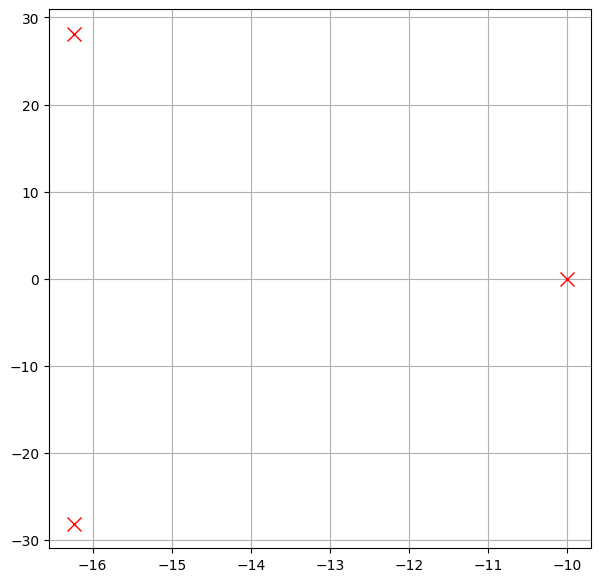

In [79]:
poles = sys_simp.poles()
p_r = [elem.real for elem in poles]
p_i = [elem.imag for elem in poles]
zeros = sys_simp.zeros()
z_r = [elem.real for elem in zeros]
z_i = [elem.imag for elem in zeros]
fig, axis = plt.subplots(figsize=(7,7))
plt.plot(p_r,p_i,'rx',markerfacecolor="None",markersize=10)
plt.plot(z_r,z_i,'bo',markerfacecolor="None",markersize=10)
plt.grid()

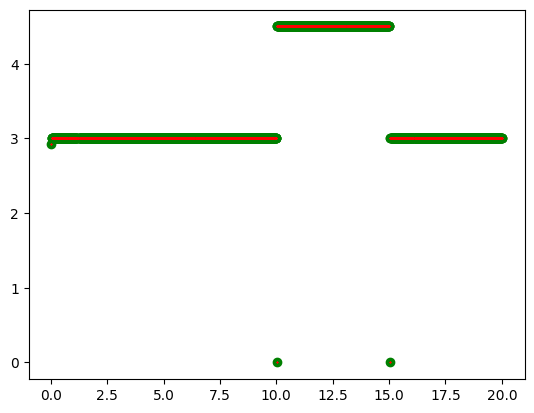

In [80]:
hz = 100
contract_exp1 = data[5][1]
relax_exp1 = data[4][1]
#u_c = np.concatenate([np.ones(10*hz)*3, np.ones(5*hz)*3.6, np.ones(5*hz)*3, np.ones(20*hz)*0], axis=0).flatten()*100000
P_g0 = np.mean(contract_exp1['p_o'].to_numpy()[0:10])
u_c = contract_exp1['p_o'].to_numpy() - P_g0
#t_c = np.linspace(0,len(u_c)//hz,len(u_c))
t_c = contract_exp1['t'].to_numpy()
fig, axis = plt.subplots()
axis.plot(t_c,(u_c+P_g0), 'go')
axis.plot(contract_exp1['t'], contract_exp1['p_o'], "rx", markersize=1)

L0 0.29054549999999996, P0 2.830875
65.26556388590609
6102.775586656745


/var/folders/z9/p239b1397052vtytn8xm0klc0000gq/T/ipykernel_97697/1084131862.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([f"{lab:0.1f}" for lab in labels], fontsize=14)
/var/folders/z9/p239b1397052vtytn8xm0klc0000gq/T/ipykernel_97697/1084131862.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([f"{lab:0.0f}" for lab in labels], fontsize=14)
/var/folders/z9/p239b1397052vtytn8xm0klc0000gq/T/ipykernel_97697/1084131862.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_yticklabels([f"{lab:0.2f}" for lab in labels], fontsize=14)
/var/folders/z9/p239b1397052vtytn8xm0klc0000gq/T/ipykernel_97697/1084131862.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[3].set_yticklabels([f"{lab:0.1f}" for lab in labels], fontsize=14)
/var/folders/z9/p239b1397052vtytn8xm0klc0000gq/T/ipykernel_97697/1084131

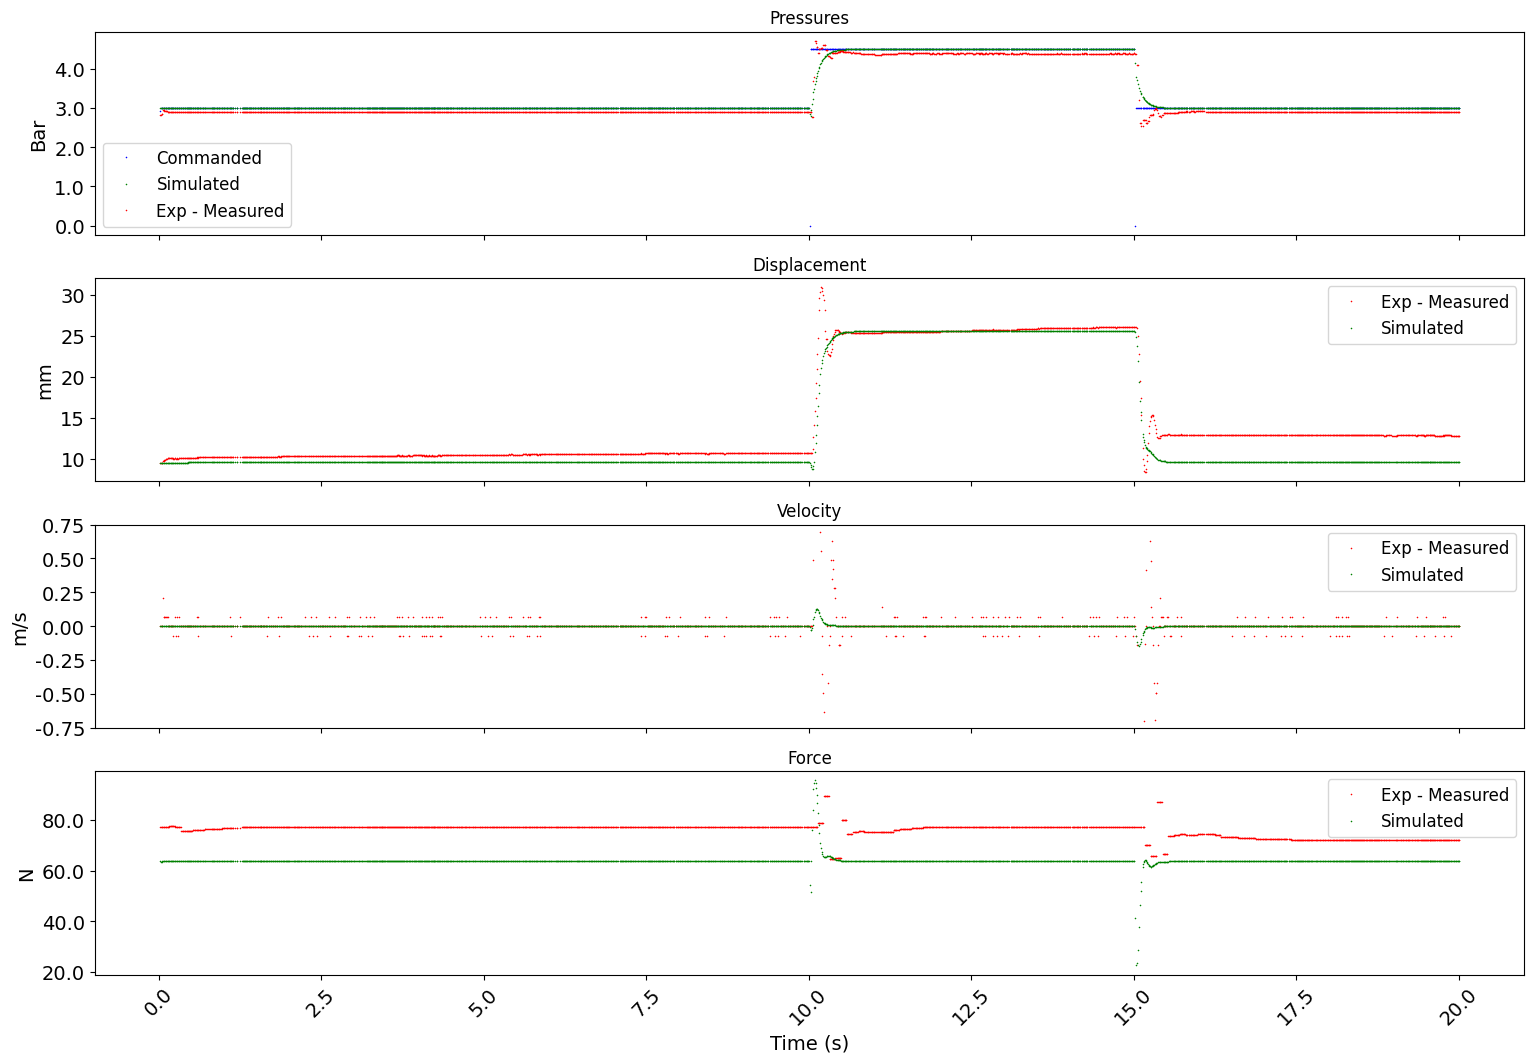

In [82]:

L_init = L_a-contract_exp1['y'].to_numpy()[0:4].mean()/1000
P_init = contract_exp1['p_p'].to_numpy()[0:4].mean()
print(f"L0 {L_init}, P0 {P_init}")
mass = 6.5
A,B,C,D = get_model(P_init, L_init, mass)
sys = ctl.StateSpace(A,B,C,D)
sysio = ctl.ss2io(sys)

contract_sim_dat = ctl.input_output_response(sysio, t_c, u_c)
fig, axes = plt.subplots(nrows=4, ncols=1,figsize=(15,10))
fig.tight_layout(pad=1)

e_pressure_c = contract_exp1['p_o'].to_numpy()
e_pressure = contract_exp1['p_p'].to_numpy()
e_disp = contract_exp1['y'].to_numpy()
e_load = 9.81*contract_exp1['l'].to_numpy()/1000

time = contract_sim_dat.time
pressure = (contract_sim_dat.outputs[0][:].T+P_g0)
disp = e_disp[0]-contract_sim_dat.outputs[1][:].T*1000
#disp = -contract_sim_dat.outputs[1][:].T*1000
vel = -contract_sim_dat.outputs[2][:].T
force = mass*9.81+contract_sim_dat.outputs[3][:].T

e_vel = np.insert(np.diff(e_disp), 0, 0)

axes[0].plot(t_c, e_pressure_c,'bx',markersize=0.5)
axes[0].plot(time, pressure,'gx',markersize=0.5)
axes[0].plot(t_c, e_pressure,'rx',markersize=0.5)
axes[0].legend(["Commanded", "Simulated","Exp - Measured"],fontsize=12)
axes[0].set_title("Pressures")
axes[0].set_ylabel("Bar", fontsize=14)

labels = axes[0].get_yticks()
axes[0].set_yticklabels([f"{lab:0.1f}" for lab in labels], fontsize=14)
axes[0].set_xticklabels([])

axes[1].plot(t_c, e_disp,'rx',markersize=0.5)
axes[1].plot(time, disp,'gx',markersize=0.5)
axes[1].legend(["Exp - Measured","Simulated"],fontsize=12)
axes[1].set_title("Displacement")
axes[1].set_ylabel("mm", fontsize=14)
axes[1].set_xticklabels([])

labels = axes[1].get_yticks()
axes[1].set_yticklabels([f"{lab:0.0f}" for lab in labels], fontsize=14)

axes[2].plot(t_c, e_vel, 'rx',markersize=0.5)
axes[2].plot(time, vel,'gx',markersize=0.5)
axes[2].legend(["Exp - Measured","Simulated"],fontsize=12)
axes[2].set_title("Velocity")
axes[2].set_ylim([-0.75,0.75])
axes[2].set_ylabel("m/s", fontsize=14)
axes[2].set_xticklabels([])

labels = axes[2].get_yticks()
axes[2].set_yticklabels([f"{lab:0.2f}" for lab in labels], fontsize=14)

axes[3].plot(t_c, e_load, 'rx',markersize=0.5)
axes[3].plot(time, force,'gx',markersize=0.5)
axes[3].legend(["Exp - Measured","Simulated"],fontsize=12)
axes[3].set_title("Force")
axes[3].set_ylabel("N", fontsize=14)
axes[3].set_xlabel("Time (s)", fontsize=14)
labels = axes[3].get_yticks()
axes[3].set_yticklabels([f"{lab:0.1f}" for lab in labels], fontsize=14)

labels = axes[3].get_xticks()
axes[3].set_xticklabels([f"{lab:0.1f}" for lab in labels], fontsize=14, rotation=45)

plt.savefig("figures/lin_sim_contraction.jpg", dpi=300)

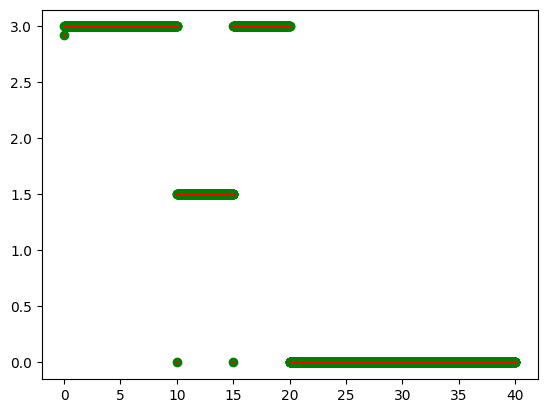

In [83]:
hz = 100
contract_exp1 = data[5][1]
relax_exp1 = data[4][1]
#u_c = np.concatenate([np.ones(10*hz)*3, np.ones(5*hz)*3.6, np.ones(5*hz)*3, np.ones(20*hz)*0], axis=0).flatten()*100000
P_g0 = np.mean(relax_exp1['p_o'].to_numpy()[0:10])
u_c = relax_exp1['p_o'].to_numpy() - P_g0
#t_c = np.linspace(0,len(u_c)//hz,len(u_c))
t_c = relax_exp1['t'].to_numpy()
fig, axis = plt.subplots()
axis.plot(t_c,(u_c+P_g0), 'go')
axis.plot(relax_exp1['t'], relax_exp1['p_o'], "rx", markersize=1)

L0 0.29032325000000003, P0 2.8411875
64.98122694253786
6104.42261303879


/var/folders/z9/p239b1397052vtytn8xm0klc0000gq/T/ipykernel_97697/3079925821.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([f"{lab:0.1f}" for lab in labels], fontsize=14)
/var/folders/z9/p239b1397052vtytn8xm0klc0000gq/T/ipykernel_97697/3079925821.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([f"{lab:0.0f}" for lab in labels], fontsize=14)
/var/folders/z9/p239b1397052vtytn8xm0klc0000gq/T/ipykernel_97697/3079925821.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_yticklabels([f"{lab:0.2f}" for lab in labels], fontsize=14)
/var/folders/z9/p239b1397052vtytn8xm0klc0000gq/T/ipykernel_97697/3079925821.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[3].set_yticklabels([f"{lab:0.1f}" for lab in labels], fontsize=14)
/var/folders/z9/p239b1397052vtytn8xm0klc0000gq/T/ipykernel_97697/3079925

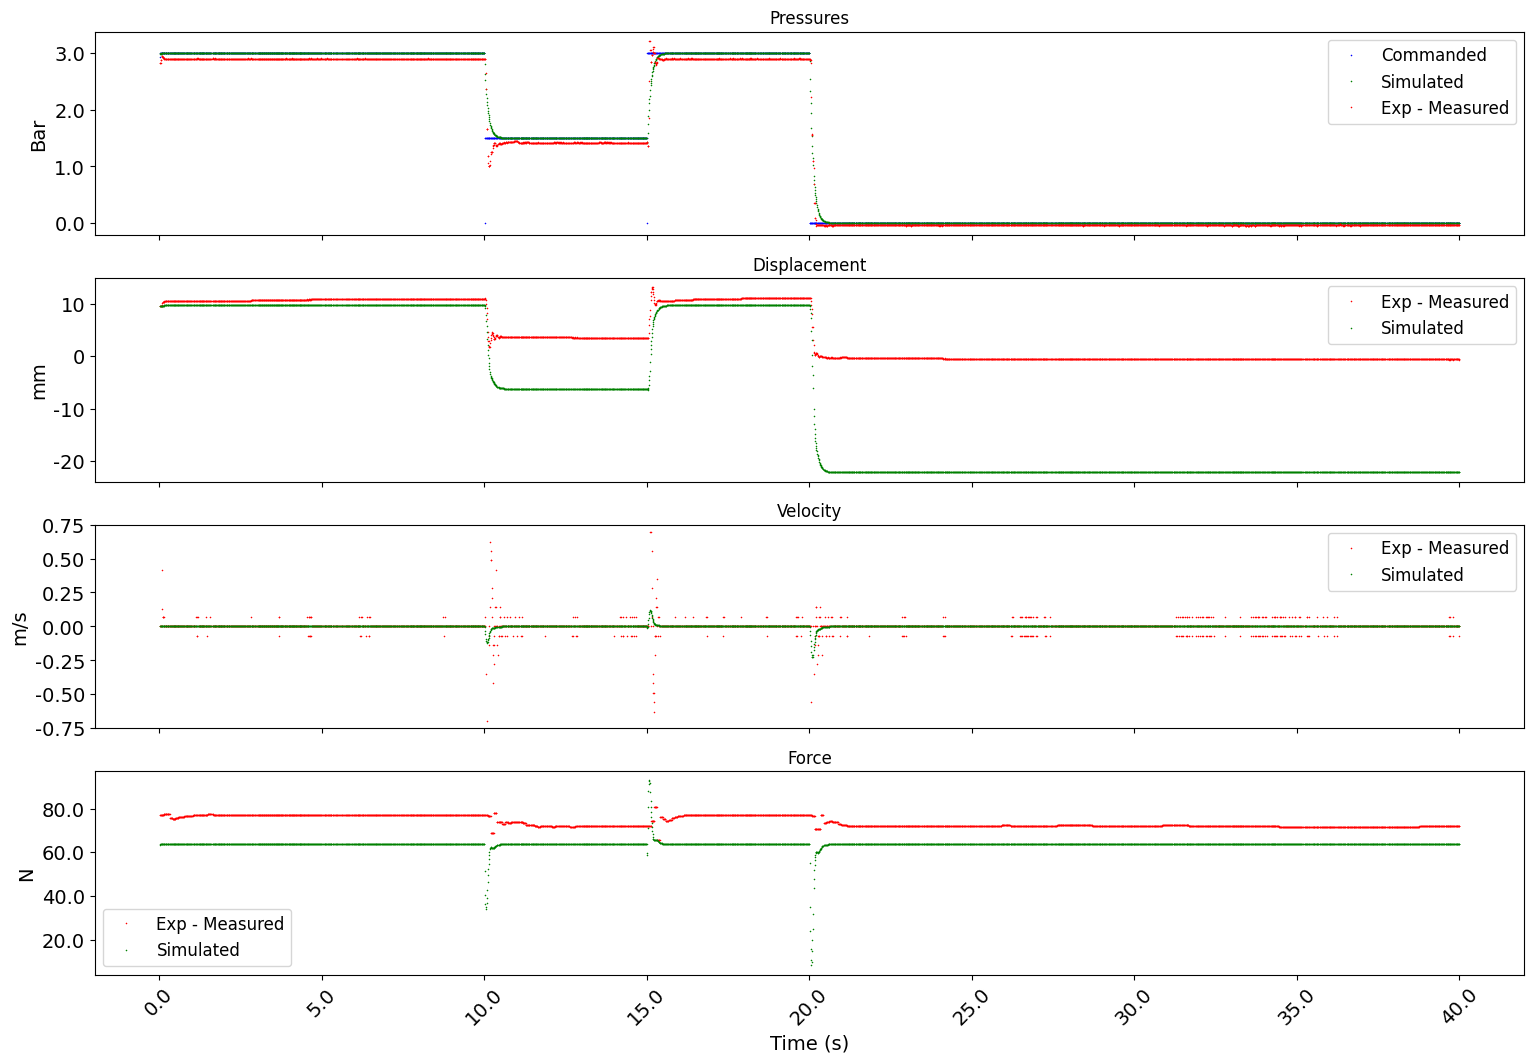

In [84]:

L_init = L_a-relax_exp1['y'].to_numpy()[0:4].mean()/1000
P_init = relax_exp1['p_p'].to_numpy()[0:4].mean()
print(f"L0 {L_init}, P0 {P_init}")
mass = 6.5
A,B,C,D = get_model(P_init, L_init, mass)
sys = ctl.StateSpace(A,B,C,D)
sysio = ctl.ss2io(sys)

relax_sim_dat = ctl.input_output_response(sysio, t_c, u_c)
fig, axes = plt.subplots(nrows=4, ncols=1,figsize=(15,10))
fig.tight_layout(pad=1)

e_pressure_c = relax_exp1['p_o'].to_numpy()
e_pressure = relax_exp1['p_p'].to_numpy()
e_disp = relax_exp1['y'].to_numpy()
e_load = 9.81*relax_exp1['l'].to_numpy()/1000

time = relax_sim_dat.time
pressure = (relax_sim_dat.outputs[0][:].T+P_g0)
disp = e_disp[0]-relax_sim_dat.outputs[1][:].T*1000
vel = -relax_sim_dat.outputs[2][:].T
force = mass*9.81+relax_sim_dat.outputs[3][:].T

e_vel = np.insert(np.diff(e_disp), 0, 0)

axes[0].plot(t_c, e_pressure_c,'bx',markersize=0.5)
axes[0].plot(time, pressure,'gx',markersize=0.5)
axes[0].plot(t_c, e_pressure,'rx',markersize=0.5)
axes[0].legend(["Commanded", "Simulated","Exp - Measured"],fontsize=12)
axes[0].set_title("Pressures")
axes[0].set_ylabel("Bar", fontsize=14)

labels = axes[0].get_yticks()
axes[0].set_yticklabels([f"{lab:0.1f}" for lab in labels], fontsize=14)
axes[0].set_xticklabels([])

axes[1].plot(t_c, e_disp,'rx',markersize=0.5)
axes[1].plot(time, disp,'gx',markersize=0.5)
axes[1].legend(["Exp - Measured","Simulated"],fontsize=12)
axes[1].set_title("Displacement")
axes[1].set_ylabel("mm", fontsize=14)
axes[1].set_xticklabels([])

labels = axes[1].get_yticks()
axes[1].set_yticklabels([f"{lab:0.0f}" for lab in labels], fontsize=14)

axes[2].plot(t_c, e_vel, 'rx',markersize=0.5)
axes[2].plot(time, vel,'gx',markersize=0.5)
axes[2].legend(["Exp - Measured","Simulated"],fontsize=12)
axes[2].set_title("Velocity")
axes[2].set_ylim([-0.75,0.75])
axes[2].set_ylabel("m/s", fontsize=14)
axes[2].set_xticklabels([])

labels = axes[2].get_yticks()
axes[2].set_yticklabels([f"{lab:0.2f}" for lab in labels], fontsize=14)

axes[3].plot(t_c, e_load, 'rx',markersize=0.5)
axes[3].plot(time, force,'gx',markersize=0.5)
axes[3].legend(["Exp - Measured","Simulated"],fontsize=12)
axes[3].set_title("Force")
axes[3].set_ylabel("N", fontsize=14)
axes[3].set_xlabel("Time (s)", fontsize=14)
labels = axes[3].get_yticks()
axes[3].set_yticklabels([f"{lab:0.1f}" for lab in labels], fontsize=14)

labels = axes[3].get_xticks()
axes[3].set_xticklabels([f"{lab:0.1f}" for lab in labels], fontsize=14, rotation=45)

plt.savefig("figures/lin_sim_relaxation.jpg", dpi=300)

In [85]:
frqs = np.arange(0.25,5+0.25,0.25)*2*np.pi

In [32]:
t = np.linspace(0,20,1000)
amplitude = 3*100000 #bar to pa
from scipy import signal
#signals = [amplitude*np.sin(elem*t) for elem in frqs]
signals = [amplitude*signal.sawtooth(elem*t) for elem in frqs]

L0 0.27, P0 300000
54.479597002383926
235385541.70373112


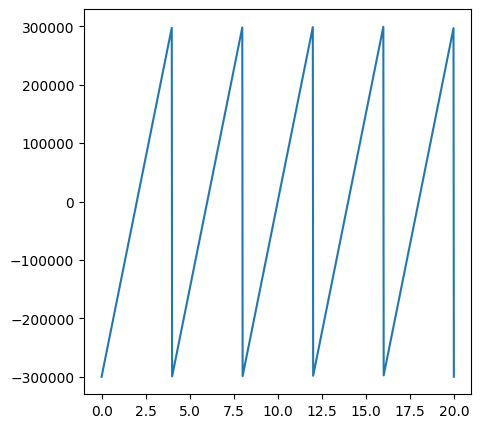

In [33]:
L_init = L_a-L_a*0.1 #10% strain
P_init = 300000
print(f"L0 {L_init}, P0 {P_init}")

A,B,C,D = get_model(P_init, L_init, 6)
sys = ctl.StateSpace(A,B,C,D)
sysio = ctl.ss2io(sys)
data_collection = []

#get all decreasing signals
diffs = [np.insert(np.diff(signal),0,0) for signal in signals]
#get the indices for all signal derivatives which are less than 0
idxs = [diffs[i]<0 for i,_ in enumerate(diffs)]

fig, h = plt.subplots(figsize=(5,5))
h.plot(t, signals[0])

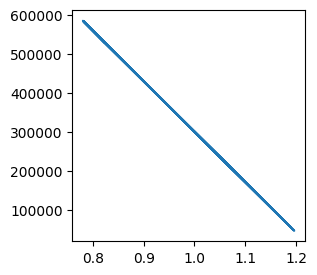

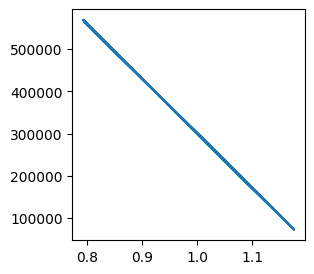

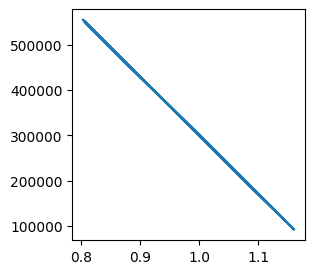

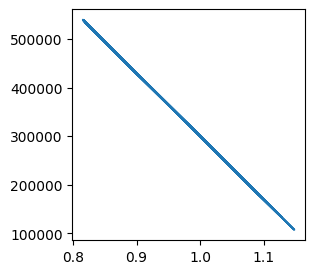

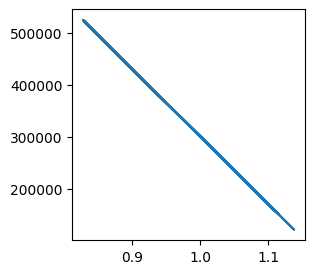

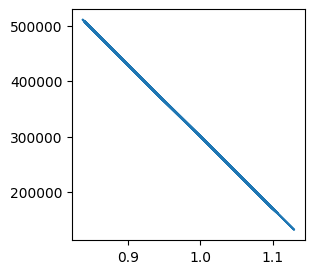

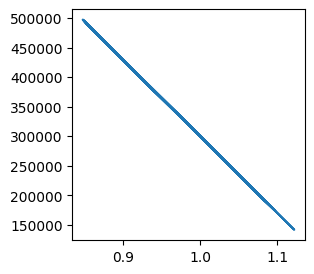

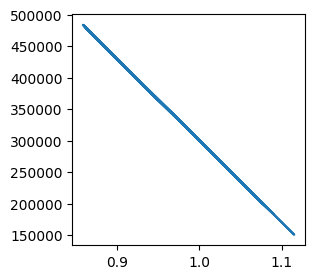

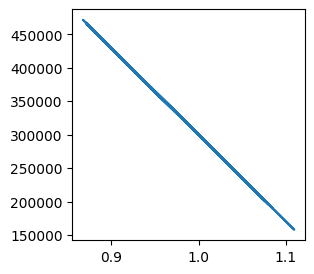

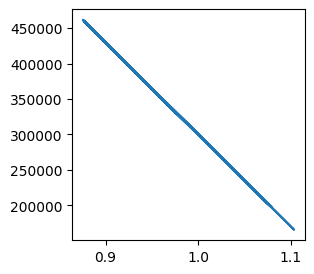

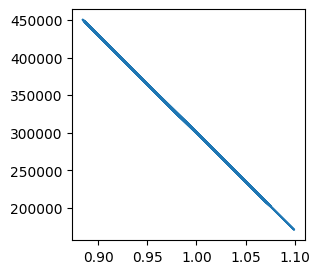

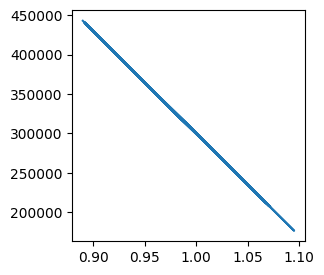

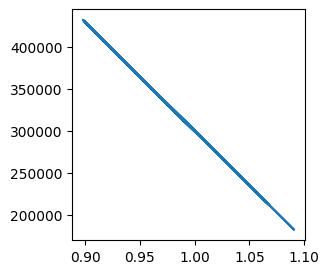

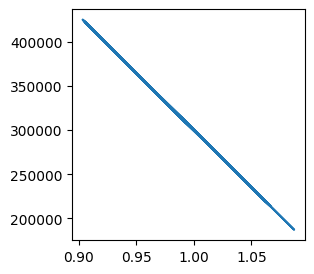

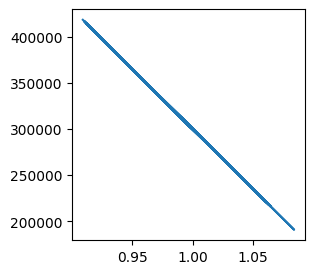

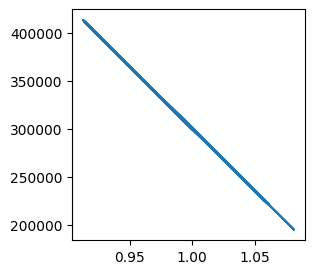

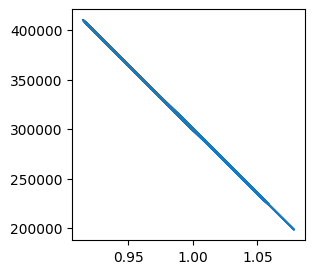

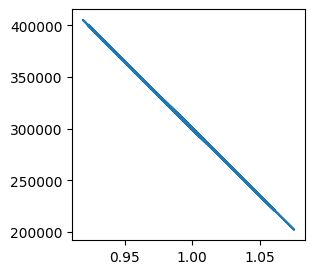

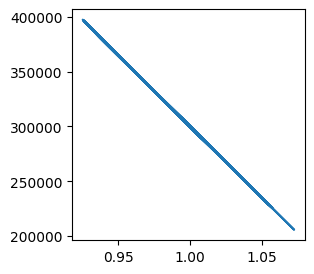

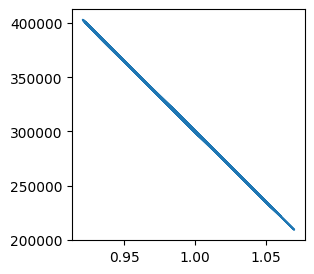

In [34]:
for idx, u in enumerate(signals):
    sim_result = ctl.input_output_response(sysio, t, u)
    fig, h = plt.subplots(figsize=(3,3))
    P = P_init+sim_result.outputs[0]
    L = L_init-sim_result.outputs[1]
    L_dot = sim_result.outputs[2]
    dF = sim_result.outputs[3]
    eps = 1+((L_a-L)/(L_a)-0.1)
    r = dict()
    r.update({"p_o":(P_init+u)/100000.0})
    r.update({"p_p":P/100000.0})
    r.update({"y":L})
    r.update({'strain':eps})
    r.update({"frq":f"{frqs[idx]:0.2f}"})
    h.plot(eps, P)
    data_collection.append(r.copy())

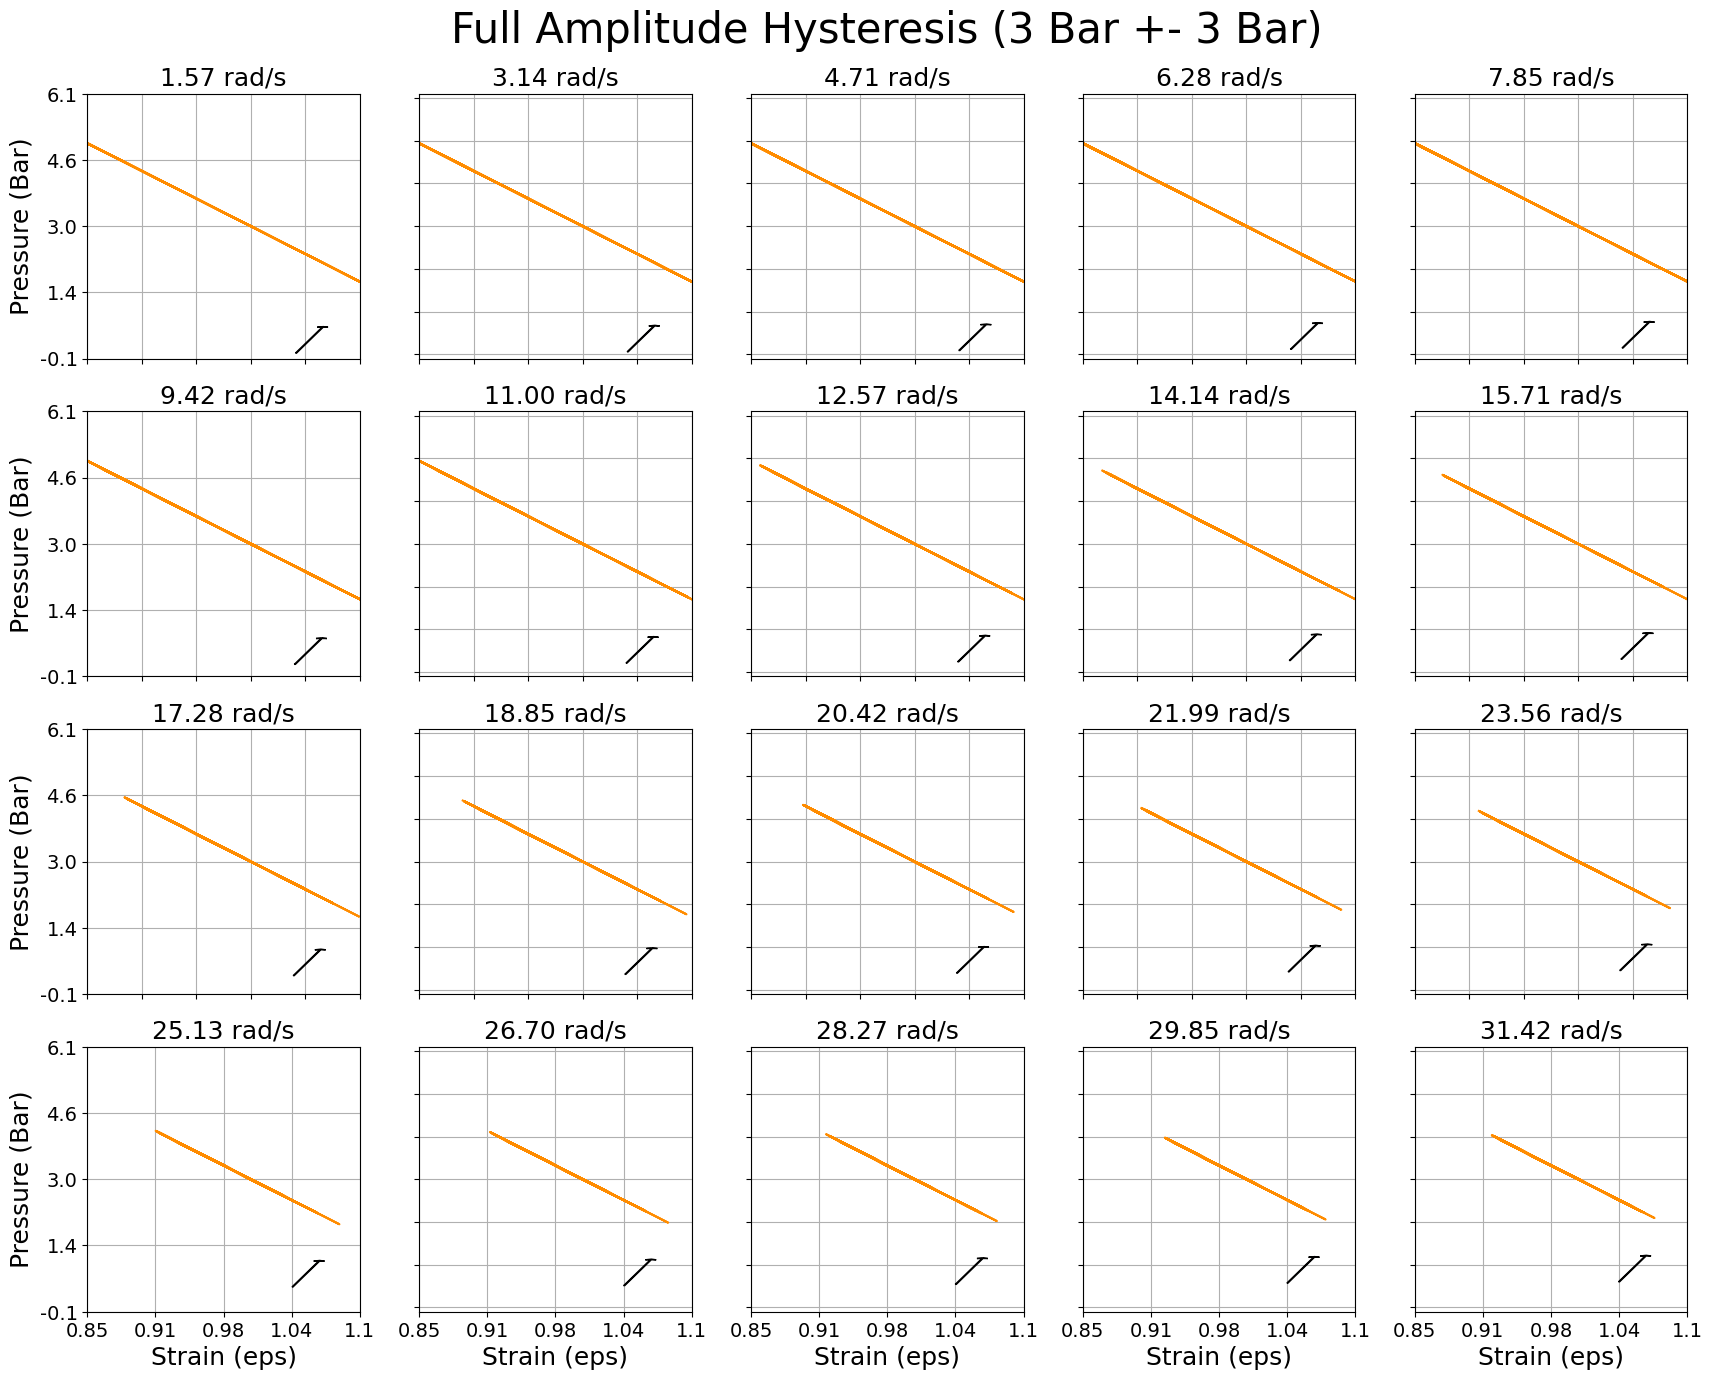

In [35]:
fig, axes = plt.subplots(nrows=4, ncols=len(data_collection)//4, figsize=(20,14))
fig.tight_layout(pad=2)
row = 0
col = 0
n_points = len(data_collection)
n_points_per_row = n_points//4

idx = 0
for data in data_collection:
    name = data["frq"]+" rad/s"
    dat = data
    h = axes[row][col]
    a_0x = dat['strain'][1]
    a_0y = dat['p_o'][1]
    a_dx = np.diff(dat['strain'][1:6]).mean()
    a_dy = np.diff(dat['p_o'][1:6]).mean()
    sa_dx = a_dx/abs(a_dx)
    sa_dy = a_dy/abs(a_dy)
    mag=0.1
    x_min = 0.85
    x_max = 1.1
    y_min = -0.1
    y_max = 6.1
    x_span = x_max-x_min
    y_span = y_max-y_min
    h.arrow(a_0x, a_0y, x_span*mag*sa_dx, y_span*mag*sa_dy, shape='full', lw=1, length_includes_head=True, head_width=.01, zorder=10)
    
    h.plot(dat['strain'], dat['p_p'], color="darkorange")
    
    h.set_title(name, fontsize=18)
    h.set_xlim((x_min, x_max))
    h.set_ylim((y_min, y_max))
    h.axes.yaxis.set_ticklabels([])
    h.axes.xaxis.set_ticklabels([])
    if row==0:
        fig.subplots_adjust(top=1)
    if col == 0:
        h.set_ylabel("Pressure (Bar)", fontsize=18)
        y_ticks = np.linspace(y_min,y_max,5)
        h.set_yticks(y_ticks)
        h.axes.yaxis.set_ticklabels([round(elem, 1) for elem in y_ticks])
        h.tick_params(axis='y', which='major', labelsize=14)
    if row == 3:
        h.set_xlabel("Strain (eps)", fontsize=18)
        x_ticks = np.linspace(x_min,x_max,5)
        h.set_xticks(x_ticks, fontsize=18)
        h.axes.xaxis.set_ticklabels([round(elem, 2) for elem in x_ticks])
        h.tick_params(axis='x', which='major', labelsize=14)
    h.grid()
    col+=1
    if(col == n_points_per_row):
        col = 0
        row+=1
plt.subplots_adjust(top=0.92, left=0.1, right=0.9, bottom=0.05)
fig.suptitle("Full Amplitude Hysteresis (3 Bar +- 3 Bar)", fontsize=30, x=0.5, y=0.98)
plt.savefig("figures/simulated_hysteresis_full_amp_st.png")